In [79]:
# mount gdrive

from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/ANDL/Homework_1

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/ANDL/Homework_1


In [48]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import adam_v2

import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import tensorflow.keras as tfk
import random
import os
import tensorflow as tf
from PIL import Image

In [49]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [50]:
# Dataset folders 
dataset_dir = 'atMost300'
training_dir = os.path.join(dataset_dir, 'train')
validation_dir = os.path.join(dataset_dir, 'val')
test_dir = os.path.join(dataset_dir, 'test')

labels = ['Species1','Species2','Species3','Species4','Species5','Species6','Species7','Species8',]

Text(0.5, 1.0, 'Number of training images per category:')

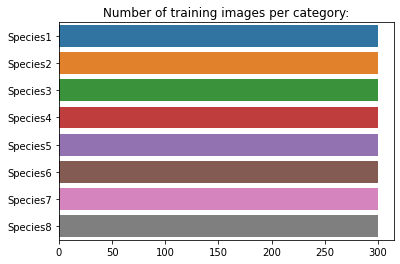

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns
category_names = sorted(os.listdir(training_dir))
nb_categories = len(category_names)
img_pr_cat = []
for category in category_names:
    folder = training_dir + '/' + category
    img_pr_cat.append(len(os.listdir(folder)))
sns.barplot(y=category_names, x=img_pr_cat).set_title("Number of training images per category:")

In [52]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import array_to_img, img_to_array, load_img

# Create an instance of ImageDataGenerator with Data Augmentation
aug_train_data_gen = ImageDataGenerator(#rotation_range=180,
                                        height_shift_range=5,
                                        width_shift_range=5,
                                        #zoom_range=0.5,
                                        horizontal_flip=True,
                                        vertical_flip=True, 
                                        #fill_mode='nearest',
                                        preprocessing_function = preprocess_input,
                                        # rescale=1/255. not on vgg16
                                        ) 
valid_data_gen = ImageDataGenerator(#rescale=1/255.,
                                    preprocessing_function = preprocess_input)
test_data_gen = ImageDataGenerator(#rescale=1/255.,
                                   preprocessing_function = preprocess_input)

In [53]:
# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
aug_train_gen = aug_train_data_gen.flow_from_directory(directory=training_dir,
                                                       target_size=(96,96),
                                                       color_mode='rgb',
                                                       classes=None, # can be set to labels
                                                       class_mode='categorical',
                                                       batch_size=32,
                                                       shuffle=True,
                                                       seed=seed)

valid_gen = valid_data_gen.flow_from_directory(directory=validation_dir,
                                               target_size=(96,96),
                                               color_mode='rgb',
                                               classes=None, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=32,
                                               shuffle=True,
                                               seed=seed)
test_gen = test_data_gen.flow_from_directory(directory=test_dir,
                                             target_size=(96,96),
                                             color_mode='rgb',
                                             classes=None, # can be set to labels
                                             class_mode='categorical',
                                             batch_size=32,
                                             shuffle=False,
                                             seed=seed)

Found 2400 images belonging to 8 classes.
Found 527 images belonging to 8 classes.
Found 361 images belonging to 8 classes.


In [54]:
def get_next_batch(generator):
  batch = next(generator)

  image = batch[0]
  target = batch[1]

  print("(Input) image shape:", image.shape)
  print("Target shape:",target.shape)

  # Visualize only the first sample
  image = image[0]
  target = target[0]
  target_idx = np.argmax(target)
  print()
  print("Categorical label:", target)
  print("Label:", target_idx)
  print("Class name:", labels[target_idx])
  fig = plt.figure(figsize=(6, 4))
  plt.imshow(np.uint8(image))

  return batch

(Input) image shape: (32, 96, 96, 3)
Target shape: (32, 8)

Categorical label: [0. 0. 0. 0. 0. 0. 1. 0.]
Label: 6
Class name: Species7


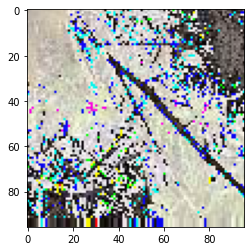

In [55]:
# Get a sample from dataset and show info
_ = get_next_batch(aug_train_gen)

In [56]:
# Utility function to create folders and callbacks for training
from datetime import datetime

def create_folders_and_callbacks(model_name):

  exps_dir = os.path.join('data_augmentation_experiments')
  if not os.path.exists(exps_dir):
      os.makedirs(exps_dir)

  now = datetime.now().strftime('%b%d_%H-%M-%S')

  exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
  if not os.path.exists(exp_dir):
      os.makedirs(exp_dir)
      
  callbacks = []

  # Model checkpoint
  # ----------------
  ckpt_dir = os.path.join(exp_dir, 'ckpts')
  if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)

  ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'), 
                                                     save_weights_only=False, # True to save only weights
                                                     save_best_only=False) # True to save only the best epoch 
  callbacks.append(ckpt_callback)

  # Visualize Learning on Tensorboard
  # ---------------------------------
  tb_dir = os.path.join(exp_dir, 'tb_logs')
  if not os.path.exists(tb_dir):
      os.makedirs(tb_dir)
      
  # By default shows losses and metrics for both training and validation
  tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir, 
                                               profile_batch=0,
                                               histogram_freq=1)  # if > 0 (epochs) shows weights histograms
  callbacks.append(tb_callback)

  # Early Stopping
  # --------------
  es_callback  = tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)
  callbacks.append(es_callback)

  return callbacks

58889256/58889256 [==============================] - 2s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 96, 96, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 96, 96, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 48, 48, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 48, 48, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 48, 48, 128)       147584    
                                                              

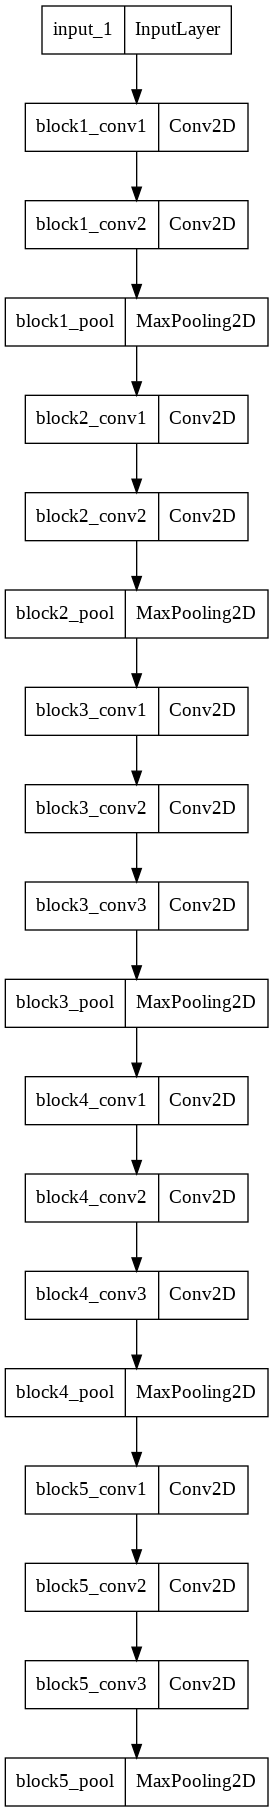

In [ ]:
# Download and plot the VGG16 model
supernet = tfk.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(96,96,3)
)
supernet.summary()
tfk.utils.plot_model(supernet)

In [27]:
input_shape = (96, 96, 3)
epochs = 200

In [28]:
import tensorflow.keras.layers as tfkl

# Use the supernet as feature extractor
supernet.trainable = False

inputs = tfk.Input(shape=(96,96,3))
# No resize
#x = tfkl.Resizing(64, 64, interpolation="bicubic")(inputs)
x = supernet(inputs)
x = tfkl.Flatten(name='Flattening')(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
x = tfkl.Dense(
    256, 
    activation='relu',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
output_layer = tfkl.Dense(units=8, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='Output')(x)



# Connect input and output through the Model class
tl_model = tfk.Model(inputs=inputs, outputs=output_layer, name='model')

# Compile the model
tl_model.compile(loss='categorical_crossentropy', optimizer=tfk.optimizers.Adam(), metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
tl_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 Flattening (Flatten)        (None, 4608)              0         
                                                                 
 dropout_2 (Dropout)         (None, 4608)              0         
                                                                 
 dense_1 (Dense)             (None, 256)               1179904   
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 Output (Dense)              (None, 8)                 2056  

In [29]:
for i, layer in enumerate(tl_model.get_layer('vgg16').layers):
   layer.trainable = False

for i, layer in enumerate(tl_model.get_layer('vgg16').layers):
   print(i, layer.name, layer.trainable)

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 False
16 block5_conv2 False
17 block5_conv3 False
18 block5_pool False


In [30]:
# Train the model
tl_callbacks = create_folders_and_callbacks(model_name = 'transfer_learning')

# Train the model
tl_history = tl_model.fit(
    x = aug_train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    callbacks = tl_callbacks,
    #class_weight=class_weight
).history

Epoch 1/200
75/75 [==============================] - ETA: 0s - loss: 5.1358 - accuracy: 0.3433 - precision_1: 0.3659 - recall_1: 0.3008

75/75 [==============================] - 24s 313ms/step - loss: 5.1358 - accuracy: 0.3433 - precision_1: 0.3659 - recall_1: 0.3008 - val_loss: 1.6110 - val_accuracy: 0.4307 - val_precision_1: 0.6091 - val_recall_1: 0.1271
Epoch 2/200
75/75 [==============================] - ETA: 0s - loss: 1.6952 - accuracy: 0.4363 - precision_1: 0.5486 - recall_1: 0.2800

75/75 [==============================] - 17s 227ms/step - loss: 1.6952 - accuracy: 0.4363 - precision_1: 0.5486 - recall_1: 0.2800 - val_loss: 1.3263 - val_accuracy: 0.4915 - val_precision_1: 0.7349 - val_recall_1: 0.2315
Epoch 3/200
75/75 [==============================] - ETA: 0s - loss: 1.5355 - accuracy: 0.4762 - precision_1: 0.6035 - recall_1: 0.3196

75/75 [==============================] - 18s 244ms/step - loss: 1.5355 - accuracy: 0.4762 - precision_1: 0.6035 - recall_1: 0.3196 - val_loss: 1.2366 - val_accuracy: 0.5332 - val_precision_1: 0.7876 - val_recall_1: 0.2884
Epoch 4/200
75/75 [==============================] - ETA: 0s - loss: 1.3754 - accuracy: 0.5121 - precision_1: 0.6602 - recall_1: 0.3571

75/75 [==============================] - 16s 211ms/step - loss: 1.3754 - accuracy: 0.5121 - precision_1: 0.6602 - recall_1: 0.3571 - val_loss: 1.2394 - val_accuracy: 0.5446 - val_precision_1: 0.7740 - val_recall_1: 0.2600
Epoch 5/200
75/75 [==============================] - ETA: 0s - loss: 1.2814 - accuracy: 0.5421 - precision_1: 0.6811 - recall_1: 0.3808

75/75 [==============================] - 18s 238ms/step - loss: 1.2814 - accuracy: 0.5421 - precision_1: 0.6811 - recall_1: 0.3808 - val_loss: 1.1850 - val_accuracy: 0.5427 - val_precision_1: 0.7132 - val_recall_1: 0.3586
Epoch 6/200
75/75 [==============================] - ETA: 0s - loss: 1.2094 - accuracy: 0.5404 - precision_1: 0.6711 - recall_1: 0.4038

75/75 [==============================] - 15s 207ms/step - loss: 1.2094 - accuracy: 0.5404 - precision_1: 0.6711 - recall_1: 0.4038 - val_loss: 1.1669 - val_accuracy: 0.5313 - val_precision_1: 0.7594 - val_recall_1: 0.3833
Epoch 7/200
75/75 [==============================] - ETA: 0s - loss: 1.2213 - accuracy: 0.5504 - precision_1: 0.6817 - recall_1: 0.4033

75/75 [==============================] - 18s 235ms/step - loss: 1.2213 - accuracy: 0.5504 - precision_1: 0.6817 - recall_1: 0.4033 - val_loss: 1.1514 - val_accuracy: 0.5560 - val_precision_1: 0.7352 - val_recall_1: 0.4004
Epoch 8/200
75/75 [==============================] - ETA: 0s - loss: 1.1354 - accuracy: 0.5933 - precision_1: 0.7194 - recall_1: 0.4508

75/75 [==============================] - 17s 231ms/step - loss: 1.1354 - accuracy: 0.5933 - precision_1: 0.7194 - recall_1: 0.4508 - val_loss: 1.1183 - val_accuracy: 0.5806 - val_precision_1: 0.7435 - val_recall_1: 0.4345
Epoch 9/200
75/75 [==============================] - ETA: 0s - loss: 1.1218 - accuracy: 0.6037 - precision_1: 0.7309 - recall_1: 0.4787

75/75 [==============================] - 17s 222ms/step - loss: 1.1218 - accuracy: 0.6037 - precision_1: 0.7309 - recall_1: 0.4787 - val_loss: 1.0717 - val_accuracy: 0.5996 - val_precision_1: 0.7381 - val_recall_1: 0.4706
Epoch 10/200
75/75 [==============================] - ETA: 0s - loss: 1.0688 - accuracy: 0.5946 - precision_1: 0.7067 - recall_1: 0.4729

75/75 [==============================] - 16s 211ms/step - loss: 1.0688 - accuracy: 0.5946 - precision_1: 0.7067 - recall_1: 0.4729 - val_loss: 1.0536 - val_accuracy: 0.5769 - val_precision_1: 0.7262 - val_recall_1: 0.4478
Epoch 11/200
75/75 [==============================] - ETA: 0s - loss: 1.0490 - accuracy: 0.6183 - precision_1: 0.7186 - recall_1: 0.5013

75/75 [==============================] - 16s 218ms/step - loss: 1.0490 - accuracy: 0.6183 - precision_1: 0.7186 - recall_1: 0.5013 - val_loss: 1.0412 - val_accuracy: 0.5977 - val_precision_1: 0.7492 - val_recall_1: 0.4421
Epoch 12/200
75/75 [==============================] - ETA: 0s - loss: 1.0214 - accuracy: 0.6329 - precision_1: 0.7363 - recall_1: 0.5154

75/75 [==============================] - 17s 223ms/step - loss: 1.0214 - accuracy: 0.6329 - precision_1: 0.7363 - recall_1: 0.5154 - val_loss: 1.0762 - val_accuracy: 0.5920 - val_precision_1: 0.7156 - val_recall_1: 0.4440
Epoch 13/200
75/75 [==============================] - ETA: 0s - loss: 0.9928 - accuracy: 0.6408 - precision_1: 0.7433 - recall_1: 0.5296

75/75 [==============================] - 16s 210ms/step - loss: 0.9928 - accuracy: 0.6408 - precision_1: 0.7433 - recall_1: 0.5296 - val_loss: 1.1299 - val_accuracy: 0.5825 - val_precision_1: 0.7323 - val_recall_1: 0.4516
Epoch 14/200
75/75 [==============================] - ETA: 0s - loss: 0.9679 - accuracy: 0.6504 - precision_1: 0.7459 - recall_1: 0.5246

75/75 [==============================] - 16s 210ms/step - loss: 0.9679 - accuracy: 0.6504 - precision_1: 0.7459 - recall_1: 0.5246 - val_loss: 1.0547 - val_accuracy: 0.6129 - val_precision_1: 0.7570 - val_recall_1: 0.4611
Epoch 15/200
75/75 [==============================] - ETA: 0s - loss: 0.9431 - accuracy: 0.6642 - precision_1: 0.7572 - recall_1: 0.5508

75/75 [==============================] - 16s 209ms/step - loss: 0.9431 - accuracy: 0.6642 - precision_1: 0.7572 - recall_1: 0.5508 - val_loss: 1.0639 - val_accuracy: 0.6148 - val_precision_1: 0.7357 - val_recall_1: 0.4649
Epoch 16/200
75/75 [==============================] - ETA: 0s - loss: 0.9385 - accuracy: 0.6567 - precision_1: 0.7521 - recall_1: 0.5487

75/75 [==============================] - 16s 220ms/step - loss: 0.9385 - accuracy: 0.6567 - precision_1: 0.7521 - recall_1: 0.5487 - val_loss: 1.0827 - val_accuracy: 0.5977 - val_precision_1: 0.6817 - val_recall_1: 0.4877
Epoch 17/200
75/75 [==============================] - ETA: 0s - loss: 0.9529 - accuracy: 0.6383 - precision_1: 0.7385 - recall_1: 0.5238

75/75 [==============================] - 16s 211ms/step - loss: 0.9529 - accuracy: 0.6383 - precision_1: 0.7385 - recall_1: 0.5238 - val_loss: 1.0301 - val_accuracy: 0.6357 - val_precision_1: 0.7333 - val_recall_1: 0.5009
Epoch 18/200
75/75 [==============================] - ETA: 0s - loss: 0.9146 - accuracy: 0.6696 - precision_1: 0.7600 - recall_1: 0.5633

75/75 [==============================] - 16s 211ms/step - loss: 0.9146 - accuracy: 0.6696 - precision_1: 0.7600 - recall_1: 0.5633 - val_loss: 1.0967 - val_accuracy: 0.6053 - val_precision_1: 0.7321 - val_recall_1: 0.4668
Epoch 19/200
75/75 [==============================] - ETA: 0s - loss: 0.9588 - accuracy: 0.6587 - precision_1: 0.7538 - recall_1: 0.5575

75/75 [==============================] - 16s 208ms/step - loss: 0.9588 - accuracy: 0.6587 - precision_1: 0.7538 - recall_1: 0.5575 - val_loss: 1.0040 - val_accuracy: 0.6148 - val_precision_1: 0.7522 - val_recall_1: 0.4896
Epoch 20/200
75/75 [==============================] - ETA: 0s - loss: 0.8435 - accuracy: 0.6767 - precision_1: 0.7730 - recall_1: 0.5875

75/75 [==============================] - 17s 221ms/step - loss: 0.8435 - accuracy: 0.6767 - precision_1: 0.7730 - recall_1: 0.5875 - val_loss: 1.0189 - val_accuracy: 0.6243 - val_precision_1: 0.7421 - val_recall_1: 0.4915
Epoch 21/200
75/75 [==============================] - ETA: 0s - loss: 0.8493 - accuracy: 0.6821 - precision_1: 0.7765 - recall_1: 0.5833

75/75 [==============================] - 16s 213ms/step - loss: 0.8493 - accuracy: 0.6821 - precision_1: 0.7765 - recall_1: 0.5833 - val_loss: 0.9366 - val_accuracy: 0.6565 - val_precision_1: 0.7811 - val_recall_1: 0.5484
Epoch 22/200
75/75 [==============================] - ETA: 0s - loss: 0.8538 - accuracy: 0.6892 - precision_1: 0.7819 - recall_1: 0.6108

75/75 [==============================] - 16s 211ms/step - loss: 0.8538 - accuracy: 0.6892 - precision_1: 0.7819 - recall_1: 0.6108 - val_loss: 1.0255 - val_accuracy: 0.6129 - val_precision_1: 0.7620 - val_recall_1: 0.4801
Epoch 23/200
75/75 [==============================] - ETA: 0s - loss: 0.8846 - accuracy: 0.6704 - precision_1: 0.7680 - recall_1: 0.5767

75/75 [==============================] - 16s 217ms/step - loss: 0.8846 - accuracy: 0.6704 - precision_1: 0.7680 - recall_1: 0.5767 - val_loss: 1.0173 - val_accuracy: 0.6622 - val_precision_1: 0.7639 - val_recall_1: 0.5465
Epoch 24/200
75/75 [==============================] - ETA: 0s - loss: 0.8658 - accuracy: 0.6888 - precision_1: 0.7894 - recall_1: 0.5904

75/75 [==============================] - 16s 211ms/step - loss: 0.8658 - accuracy: 0.6888 - precision_1: 0.7894 - recall_1: 0.5904 - val_loss: 0.9452 - val_accuracy: 0.6490 - val_precision_1: 0.7759 - val_recall_1: 0.5256
Epoch 25/200
75/75 [==============================] - ETA: 0s - loss: 0.8447 - accuracy: 0.6958 - precision_1: 0.7789 - recall_1: 0.6092

75/75 [==============================] - 15s 204ms/step - loss: 0.8447 - accuracy: 0.6958 - precision_1: 0.7789 - recall_1: 0.6092 - val_loss: 1.0071 - val_accuracy: 0.6224 - val_precision_1: 0.7406 - val_recall_1: 0.4877
Epoch 26/200
75/75 [==============================] - ETA: 0s - loss: 0.8605 - accuracy: 0.6787 - precision_1: 0.7884 - recall_1: 0.5775

75/75 [==============================] - 16s 210ms/step - loss: 0.8605 - accuracy: 0.6787 - precision_1: 0.7884 - recall_1: 0.5775 - val_loss: 0.9334 - val_accuracy: 0.6603 - val_precision_1: 0.7674 - val_recall_1: 0.5446
Epoch 27/200
75/75 [==============================] - ETA: 0s - loss: 0.8217 - accuracy: 0.6842 - precision_1: 0.7951 - recall_1: 0.6029

75/75 [==============================] - 16s 219ms/step - loss: 0.8217 - accuracy: 0.6842 - precision_1: 0.7951 - recall_1: 0.6029 - val_loss: 0.9736 - val_accuracy: 0.6319 - val_precision_1: 0.7473 - val_recall_1: 0.5332
Epoch 28/200
75/75 [==============================] - ETA: 0s - loss: 0.7877 - accuracy: 0.7071 - precision_1: 0.8038 - recall_1: 0.6179

75/75 [==============================] - 16s 212ms/step - loss: 0.7877 - accuracy: 0.7071 - precision_1: 0.8038 - recall_1: 0.6179 - val_loss: 1.0031 - val_accuracy: 0.6376 - val_precision_1: 0.7455 - val_recall_1: 0.5503
Epoch 29/200
75/75 [==============================] - ETA: 0s - loss: 0.7934 - accuracy: 0.7125 - precision_1: 0.7967 - recall_1: 0.6237

75/75 [==============================] - 15s 206ms/step - loss: 0.7934 - accuracy: 0.7125 - precision_1: 0.7967 - recall_1: 0.6237 - val_loss: 1.0459 - val_accuracy: 0.6300 - val_precision_1: 0.7344 - val_recall_1: 0.5142
Epoch 30/200
75/75 [==============================] - ETA: 0s - loss: 0.8267 - accuracy: 0.7075 - precision_1: 0.8020 - recall_1: 0.6092

75/75 [==============================] - 16s 211ms/step - loss: 0.8267 - accuracy: 0.7075 - precision_1: 0.8020 - recall_1: 0.6092 - val_loss: 0.9866 - val_accuracy: 0.6546 - val_precision_1: 0.7579 - val_recall_1: 0.5465
Epoch 31/200
75/75 [==============================] - ETA: 0s - loss: 0.8100 - accuracy: 0.7038 - precision_1: 0.7994 - recall_1: 0.6208

75/75 [==============================] - 16s 209ms/step - loss: 0.8100 - accuracy: 0.7038 - precision_1: 0.7994 - recall_1: 0.6208 - val_loss: 0.9841 - val_accuracy: 0.6660 - val_precision_1: 0.7627 - val_recall_1: 0.5427
Epoch 32/200
75/75 [==============================] - ETA: 0s - loss: 0.8363 - accuracy: 0.6954 - precision_1: 0.7819 - recall_1: 0.6108

75/75 [==============================] - 16s 210ms/step - loss: 0.8363 - accuracy: 0.6954 - precision_1: 0.7819 - recall_1: 0.6108 - val_loss: 0.9995 - val_accuracy: 0.6281 - val_precision_1: 0.7479 - val_recall_1: 0.5180
Epoch 33/200
75/75 [==============================] - ETA: 0s - loss: 0.8282 - accuracy: 0.6971 - precision_1: 0.7932 - recall_1: 0.6154

75/75 [==============================] - 15s 207ms/step - loss: 0.8282 - accuracy: 0.6971 - precision_1: 0.7932 - recall_1: 0.6154 - val_loss: 1.0604 - val_accuracy: 0.6053 - val_precision_1: 0.7188 - val_recall_1: 0.5142
Epoch 34/200
75/75 [==============================] - ETA: 0s - loss: 0.7881 - accuracy: 0.7129 - precision_1: 0.7955 - recall_1: 0.6271

75/75 [==============================] - 17s 225ms/step - loss: 0.7881 - accuracy: 0.7129 - precision_1: 0.7955 - recall_1: 0.6271 - val_loss: 0.9775 - val_accuracy: 0.6565 - val_precision_1: 0.7481 - val_recall_1: 0.5522
Epoch 35/200
75/75 [==============================] - ETA: 0s - loss: 0.7366 - accuracy: 0.7325 - precision_1: 0.8191 - recall_1: 0.6492

75/75 [==============================] - 16s 207ms/step - loss: 0.7366 - accuracy: 0.7325 - precision_1: 0.8191 - recall_1: 0.6492 - val_loss: 1.0032 - val_accuracy: 0.6603 - val_precision_1: 0.7624 - val_recall_1: 0.5844
Epoch 36/200
75/75 [==============================] - ETA: 0s - loss: 0.7658 - accuracy: 0.7300 - precision_1: 0.8137 - recall_1: 0.6517

75/75 [==============================] - 16s 212ms/step - loss: 0.7658 - accuracy: 0.7300 - precision_1: 0.8137 - recall_1: 0.6517 - val_loss: 0.9534 - val_accuracy: 0.6584 - val_precision_1: 0.7696 - val_recall_1: 0.5958
Epoch 37/200
75/75 [==============================] - ETA: 0s - loss: 0.7696 - accuracy: 0.7287 - precision_1: 0.7970 - recall_1: 0.6413

75/75 [==============================] - 16s 208ms/step - loss: 0.7696 - accuracy: 0.7287 - precision_1: 0.7970 - recall_1: 0.6413 - val_loss: 0.9513 - val_accuracy: 0.6774 - val_precision_1: 0.7724 - val_recall_1: 0.5731
Epoch 38/200
75/75 [==============================] - ETA: 0s - loss: 0.7539 - accuracy: 0.7212 - precision_1: 0.7904 - recall_1: 0.6425

75/75 [==============================] - 17s 222ms/step - loss: 0.7539 - accuracy: 0.7212 - precision_1: 0.7904 - recall_1: 0.6425 - val_loss: 0.9338 - val_accuracy: 0.6698 - val_precision_1: 0.7760 - val_recall_1: 0.5522
Epoch 39/200
75/75 [==============================] - ETA: 0s - loss: 0.7563 - accuracy: 0.7146 - precision_1: 0.8014 - recall_1: 0.6371

75/75 [==============================] - 15s 206ms/step - loss: 0.7563 - accuracy: 0.7146 - precision_1: 0.8014 - recall_1: 0.6371 - val_loss: 0.9735 - val_accuracy: 0.6641 - val_precision_1: 0.7667 - val_recall_1: 0.5674
Epoch 40/200
75/75 [==============================] - ETA: 0s - loss: 0.7654 - accuracy: 0.7296 - precision_1: 0.8024 - recall_1: 0.6446

75/75 [==============================] - 16s 214ms/step - loss: 0.7654 - accuracy: 0.7296 - precision_1: 0.8024 - recall_1: 0.6446 - val_loss: 0.9418 - val_accuracy: 0.6698 - val_precision_1: 0.7574 - val_recall_1: 0.5806
Epoch 41/200
75/75 [==============================] - ETA: 0s - loss: 0.7645 - accuracy: 0.7304 - precision_1: 0.8094 - recall_1: 0.6529

75/75 [==============================] - 16s 214ms/step - loss: 0.7645 - accuracy: 0.7304 - precision_1: 0.8094 - recall_1: 0.6529 - val_loss: 0.9716 - val_accuracy: 0.6660 - val_precision_1: 0.7655 - val_recall_1: 0.5389
Epoch 42/200
75/75 [==============================] - ETA: 0s - loss: 0.7666 - accuracy: 0.7221 - precision_1: 0.7970 - recall_1: 0.6413

75/75 [==============================] - 16s 212ms/step - loss: 0.7666 - accuracy: 0.7221 - precision_1: 0.7970 - recall_1: 0.6413 - val_loss: 0.9783 - val_accuracy: 0.6546 - val_precision_1: 0.7784 - val_recall_1: 0.5598
Epoch 43/200
75/75 [==============================] - ETA: 0s - loss: 0.7069 - accuracy: 0.7496 - precision_1: 0.8214 - recall_1: 0.6767

75/75 [==============================] - 16s 209ms/step - loss: 0.7069 - accuracy: 0.7496 - precision_1: 0.8214 - recall_1: 0.6767 - val_loss: 0.9933 - val_accuracy: 0.6546 - val_precision_1: 0.7573 - val_recall_1: 0.5446
Epoch 44/200
75/75 [==============================] - ETA: 0s - loss: 0.7702 - accuracy: 0.7138 - precision_1: 0.7951 - recall_1: 0.6338

75/75 [==============================] - 16s 210ms/step - loss: 0.7702 - accuracy: 0.7138 - precision_1: 0.7951 - recall_1: 0.6338 - val_loss: 0.9752 - val_accuracy: 0.6603 - val_precision_1: 0.7676 - val_recall_1: 0.5389
Epoch 45/200
75/75 [==============================] - ETA: 0s - loss: 0.7466 - accuracy: 0.7342 - precision_1: 0.8155 - recall_1: 0.6629

75/75 [==============================] - 16s 220ms/step - loss: 0.7466 - accuracy: 0.7342 - precision_1: 0.8155 - recall_1: 0.6629 - val_loss: 0.9900 - val_accuracy: 0.6717 - val_precision_1: 0.7580 - val_recall_1: 0.5825
Epoch 46/200
75/75 [==============================] - ETA: 0s - loss: 0.7155 - accuracy: 0.7396 - precision_1: 0.8111 - recall_1: 0.6675

75/75 [==============================] - 16s 209ms/step - loss: 0.7155 - accuracy: 0.7396 - precision_1: 0.8111 - recall_1: 0.6675 - val_loss: 0.9220 - val_accuracy: 0.6660 - val_precision_1: 0.7723 - val_recall_1: 0.5598
Epoch 47/200
75/75 [==============================] - ETA: 0s - loss: 0.6978 - accuracy: 0.7429 - precision_1: 0.8183 - recall_1: 0.6700

75/75 [==============================] - 15s 207ms/step - loss: 0.6978 - accuracy: 0.7429 - precision_1: 0.8183 - recall_1: 0.6700 - val_loss: 0.9944 - val_accuracy: 0.6698 - val_precision_1: 0.7598 - val_recall_1: 0.5882


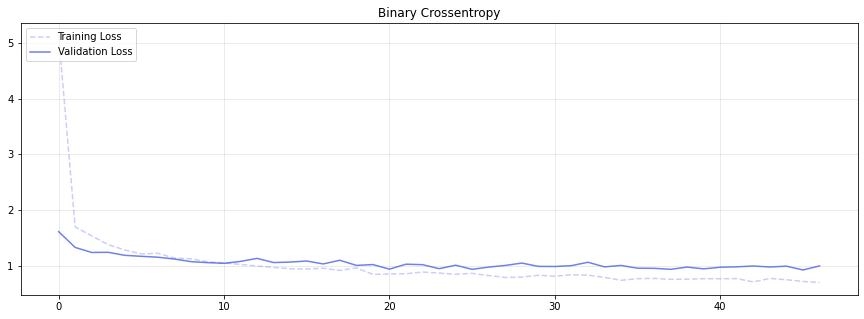

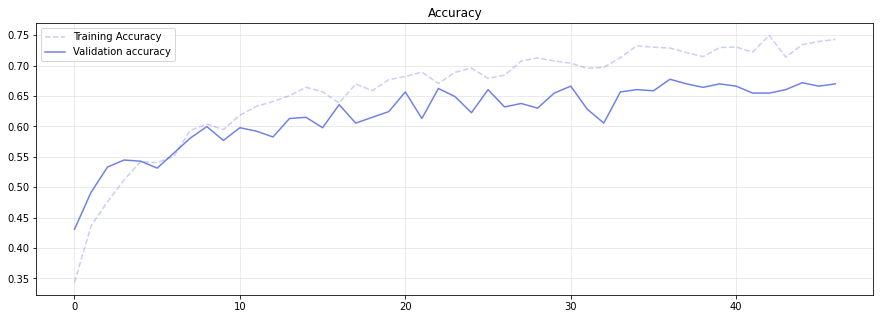

In [33]:
# Plot the training
plt.figure(figsize=(15,5))

plt.plot(tl_history['loss'],label = 'Training Loss', alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_loss'], label='Validation Loss', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))

plt.plot(tl_history['accuracy'],label = 'Training Accuracy' , alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_accuracy'], label='Validation accuracy', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [36]:
%cd Vgg16

/gdrive/MyDrive/ANDL/Homework_1/Vgg16


In [40]:
tl_model.save('FineFineTuning_v1')

In [41]:
tl_model = tfk.models.load_model('FineFineTuning_v1')
tl_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 Flattening (Flatten)        (None, 4608)              0         
                                                                 
 dropout_2 (Dropout)         (None, 4608)              0         
                                                                 
 dense_1 (Dense)             (None, 256)               1179904   
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 Output (Dense)              (None, 8)                 2056  

In [42]:
%cd /content

/content


In [43]:
tl_model.get_layer('vgg16').trainable = True
for i, layer in enumerate(tl_model.get_layer('vgg16').layers):
   print(i, layer.name, layer.trainable)

0 input_1 True
1 block1_conv1 True
2 block1_conv2 True
3 block1_pool True
4 block2_conv1 True
5 block2_conv2 True
6 block2_pool True
7 block3_conv1 True
8 block3_conv2 True
9 block3_conv3 True
10 block3_pool True
11 block4_conv1 True
12 block4_conv2 True
13 block4_conv3 True
14 block4_pool True
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


In [44]:
for i, layer in enumerate(tl_model.get_layer('vgg16').layers[:15]):
  layer.trainable=False
for i, layer in enumerate(tl_model.get_layer('vgg16').layers):
   print(i, layer.name, layer.trainable)
tl_model.summary()

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 Flattening (Flatten)        (None, 4608)              0         
                                                                 
 dropout_2 (Dropout)         (None, 4608)              0       

In [45]:
tl_model.compile(loss='categorical_crossentropy', optimizer=tfk.optimizers.Adam(1e-4), metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [57]:
# Fine-tune the model
tl_history = tl_model.fit(
    x = aug_train_gen ,
    batch_size = 32,
    epochs = 200,
    validation_data = valid_gen,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, verbose=2 , restore_best_weights=True)],
    #class_weight = class_weight
).history

Epoch 1/200
75/75 [==============================] - 18s 209ms/step - loss: 1.1271 - accuracy: 0.6062 - precision_2: 0.7076 - recall_2: 0.5204 - val_loss: 0.9823 - val_accuracy: 0.6565 - val_precision_2: 0.7553 - val_recall_2: 0.5389
Epoch 2/200
75/75 [==============================] - 11s 144ms/step - loss: 0.9903 - accuracy: 0.6579 - precision_2: 0.7560 - recall_2: 0.5550 - val_loss: 0.9694 - val_accuracy: 0.6546 - val_precision_2: 0.7318 - val_recall_2: 0.5541
Epoch 3/200
75/75 [==============================] - 11s 149ms/step - loss: 0.8598 - accuracy: 0.6913 - precision_2: 0.7833 - recall_2: 0.5858 - val_loss: 0.8902 - val_accuracy: 0.7230 - val_precision_2: 0.8030 - val_recall_2: 0.6186
Epoch 4/200
75/75 [==============================] - 14s 191ms/step - loss: 0.8024 - accuracy: 0.7167 - precision_2: 0.7992 - recall_2: 0.6283 - val_loss: 0.9093 - val_accuracy: 0.6622 - val_precision_2: 0.7620 - val_recall_2: 0.5712
Epoch 5/200
75/75 [==============================] - 11s 145ms/s

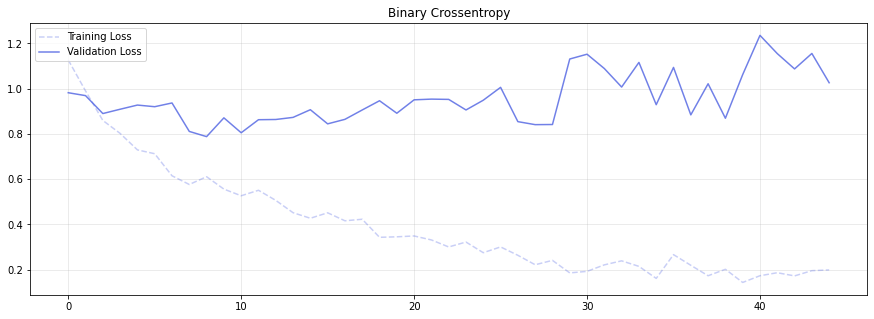

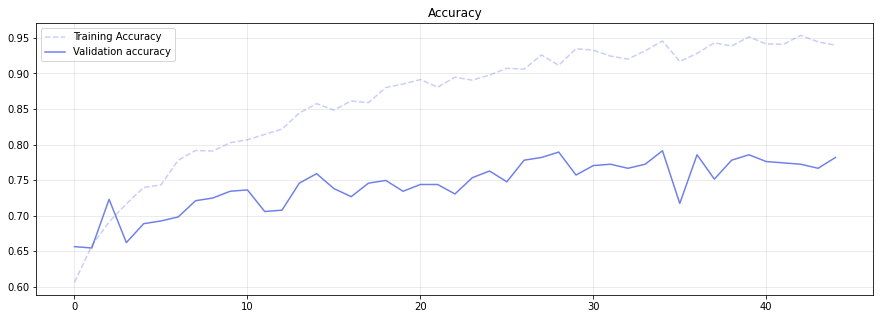

In [58]:
# Plot the training
plt.figure(figsize=(15,5))

plt.plot(tl_history['loss'],label = 'Training Loss', alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_loss'], label='Validation Loss', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))

plt.plot(tl_history['accuracy'],label = 'Training Accuracy' , alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_accuracy'], label='Validation accuracy', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [81]:
%cd /gdrive/My Drive/ANDL/Homework_1

/gdrive/My Drive/ANDL/Homework_1


In [82]:
tl_model.save('Vgg16/Tuned_v1_1')

In [83]:
# Test the model
tl_model = tfk.models.load_model("Vgg16/Tuned_v1_1")
model_test_metrics = tl_model.evaluate(test_gen, return_dict=True)

print()
print("Test metrics")
print(model_test_metrics)

12/12 [==============================] - 112s 10s/step - loss: 0.8981 - accuracy: 0.8006 - precision_2: 0.8166 - recall_2: 0.7645

Test metrics
{'loss': 0.898078978061676, 'accuracy': 0.8005540370941162, 'precision_2': 0.8165680766105652, 'recall_2': 0.7645429372787476}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """


Accuracy: 0.8006
Precision: 0.7933
Recall: 0.7867
F1: 0.7882


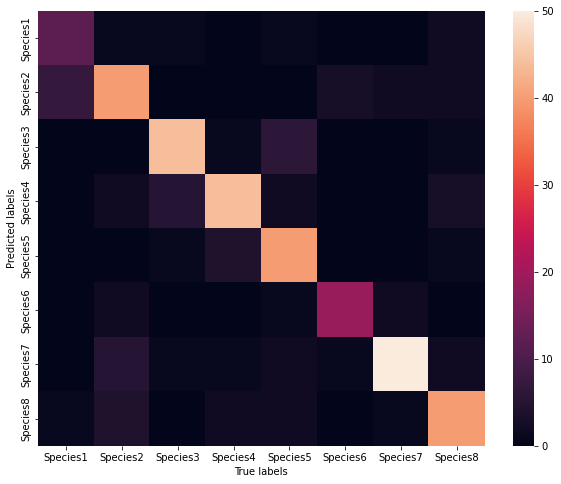

In [86]:
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

predictions = tl_model.predict_generator(test_gen, steps=224)
predicted_classes = np.argmax(predictions, axis=-1)

# Compute the confusion matrix
cm = (confusion_matrix(test_gen.classes, predicted_classes))

# Compute the classification metrics
accuracy = accuracy_score(test_gen.classes, predicted_classes)
precision = precision_score(test_gen.classes, predicted_classes, average='macro')
recall = recall_score(test_gen.classes, predicted_classes, average='macro')
f1 = f1_score(test_gen.classes, predicted_classes, average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, xticklabels=labels, yticklabels=labels)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()